In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [11]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT34,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,0.0,58931.0


In [12]:
# Create a new df of the item_id equal to IT01 
df = df[df['item_id'] == 'IT01']

In [13]:
# Remove idem_id column and target column
df = df.drop(columns=['item_id', 'target'])
df.head()

,timestamp,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT34,ACT44
348,2019-12-30,1228.0,87.0,0.0,195.0,188.0,32.0,1817.0,1255.0,2811.0,0.0,0.0
349,2020-01-06,87.0,63.0,0.0,5.0,8.0,0.0,0.0,0.0,227.0,261.0,0.0
350,2020-01-13,161.0,10.0,0.0,14.0,0.0,49.0,1.0,0.0,467.0,0.0,0.0
351,2020-01-20,437.0,143.0,0.0,86.0,67.0,110.0,0.0,0.0,98.0,0.0,0.0
352,2020-01-27,403.0,457.0,0.0,178.0,108.0,48.0,7.0,0.0,269.0,0.0,0.0


In [14]:
# Trasforma le colonne ACT in una singola colonna item_id e i valori corrispondenti in una colonna target
df = df.melt(id_vars=["timestamp"], var_name="item_id", value_name="target")

# Ordina il DataFrame per il timestamp
df.sort_values(by="timestamp", inplace=True)

# Visualizza il DataFrame trasformato
df.head(10)

,timestamp,item_id,target
0,2019-12-30,ACT01,1228.0
172,2019-12-30,ACT03,87.0
1204,2019-12-30,ACT17,1255.0
860,2019-12-30,ACT13,32.0
1548,2019-12-30,ACT34,0.0
516,2019-12-30,ACT07,195.0
1376,2019-12-30,ACT32,2811.0
688,2019-12-30,ACT09,188.0
1032,2019-12-30,ACT15,1817.0
344,2019-12-30,ACT04,0.0


In [15]:
# Drop row where item_id is ACT17 and ACT44
df = df[df['item_id'] != 'ACT17']
df = df[df['item_id'] != 'ACT34']
df = df[df['item_id'] != 'ACT44']

In [16]:
df.shape

(1376, 3)

In [17]:
prediction_length = 12  # Length of the prediction

# Convert the 'timestamp' column to datetime format if it's not already in that format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Find the maximum date in the dataset
max_date = df['timestamp'].max()

# Calculate the start date of the test set
test_start_date = max_date - pd.DateOffset(weeks=prediction_length+1)

# Split the dataset into training and test sets
train_data = df[df['timestamp'] <= test_start_date]
test_data = df[df['timestamp'] > test_start_date]

# Print the percentage dimensions of the training and test sets
print(train_data.shape[0] / df.shape[0])
print(test_data.shape[0] / df.shape[0])


0.9244186046511628
0.0755813953488372


In [18]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

,,target
item_id,timestamp,
ACT01,2019-12-30,1228.0
ACT03,2019-12-30,87.0
ACT13,2019-12-30,32.0
ACT07,2019-12-30,195.0
ACT32,2019-12-30,2811.0


In [19]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

,,target
item_id,timestamp,
ACT03,2023-01-30,147.0
ACT09,2023-01-30,166.0
ACT13,2023-01-30,196.0
ACT04,2023-01-30,0.0
ACT32,2023-01-30,2137.0


In [20]:
# Build predictor
predictor = TimeSeriesPredictor(
    prediction_length=12,
    freq='W-MON',
    target='target',
    path='weekly_final',
    eval_metric='MASE'
)

In [88]:
# Fit the model
predictor.fit(
    train_data,
    presets='best_quality',
    num_val_windows=5,
    time_limit=2400,
    random_seed=42
)

Beginning AutoGluon training... Time limit = 2400s
AutoGluon will save models to 'weekly_final'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
GPU Count:          0
Memory Avail:       5.39 GB / 15.78 GB (34.1%)
Disk Space Avail:   97.56 GB / 475.83 GB (20.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'W-MON',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 5,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'time_limit': 2400,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'W-MON'.
train_data contains missing values represented by NaN. They have bee

In [89]:
# Make prediction on training data
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.


data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1           0.2           0.3  \
item_id   timestamp                                                           
FR13total 2023-01-30  18069.219439  3119.865285  13184.550672  14787.767686   
          2023-02-06   3029.493906  -561.796221    643.664167   1394.748292   
          2023-02-13   3083.634619 -1089.711709    466.387927   1443.260493   
          2023-02-20   5731.149243 -6273.101304   -692.570153   2005.240221   
          2023-02-27  38892.758166  3225.884543  14758.400242  23879.523735   

                               0.4           0.5           0.6           0.7  \
item_id   timestamp                                                            
FR13total 2023-01-30  16988.074116  18069.219439  20910.872743  22300.805161   
          2023-02-06   2259.742046   3029.493906   3856.634835   4730.446758   
          2023-02-13   2344.309169   3083.634619   3914.612326   4973.404187   
          2023-02-20   4090.480975   5731.149243   7648.559165  10402.276649   
          2023-02-27  30221.647371  38892.758166  44152.201913  51824.676376   

                               0.8           0.9  
item_id   timestamp                               
FR13total 2023-01-30  25358.026575  27708.979097  
          2023-02-06  12207.129235  14151.042379  
          2023-02-13   9990.948994  11925.979453  
          2023-02-20  19559.466925  24534.023182  
          2023-02-27  60909.304796  71468.951516

In [90]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-1537.031514,-0.719947,0.146087,0.080902,530.174344,11
1,DeepAR,-2070.639828,-0.623971,0.830468,0.563963,522.002966,9
2,CrostonSBA,-4784.767379,-0.884571,5.555849,0.082808,16.068288,2
3,TemporalFusionTransformer,-5044.908489,-0.679069,0.297820,0.089163,526.243163,10
4,NPTS,-5044.909091,-0.651767,0.173024,0.449694,1.614101,3
5,DirectTabular,-5350.364758,-0.747703,0.207194,0.132550,6.615330,8
6,WeightedEnsemble,NaN,-0.604822,1.449037,1.507308,15.685911,12
7,SeasonalNaive,NaN,-1.012824,0.185556,0.085365,4.588897,1
8,RecursiveTabular,NaN,-0.687529,0.147725,0.404488,104.578456,7
9,DynamicOptimizedTheta,NaN,-0.834873,13.149576,0.987645,22.058598,5


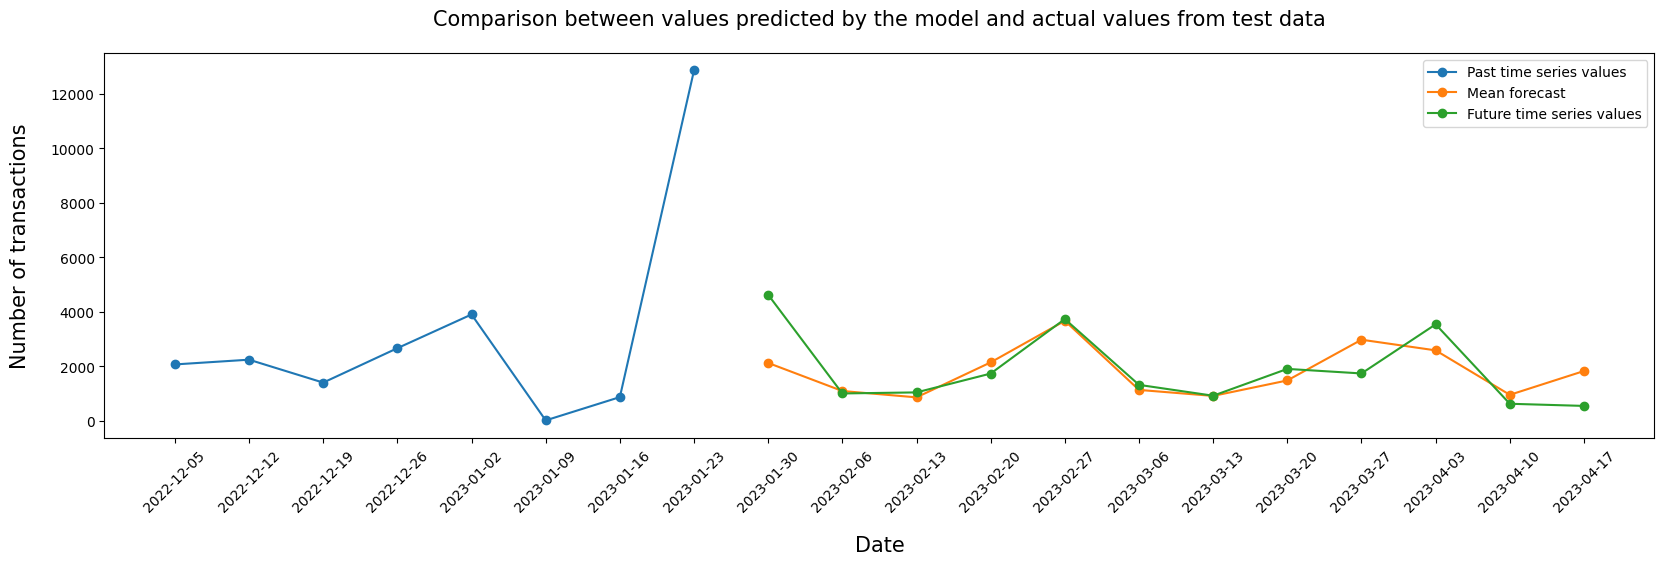

In [91]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "IT01total"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()